<a href="https://colab.research.google.com/github/linesn/reddit_analysis/blob/main/Reddit_commenter_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
The purpose of this notebook is to allow the user to group Reddit comment data by commenter and then tokenize, stem, and lemmatize the text produced by that commenter, as desired.

**WARNING:** The data shown is raw Reddit data that has not been sanitized to remove foul language nor has it been anonymized. 

## Imports and environment setup

In [4]:
%pylab inline
import os
import pandas as pd
import scipy.sparse as sp
import networkx as nx
from itertools import chain
import nltk
from nltk import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

Populating the interactive namespace from numpy and matplotlib


In [5]:
if 'COLAB_GPU' in os.environ: # a hacky way of determining if you are in colab.
  print("Notebook is running in colab")
  from google.colab import drive
  drive.mount("/content/drive")
  DATA_DIR = "./drive/My Drive/Data/"
  
else:
  # Get the system information from the OS
  PLATFORM_SYSTEM = platform.system()

  # Darwin is macOS
  if PLATFORM_SYSTEM == "Darwin":
      EXECUTABLE_PATH = Path("../dependencies/chromedriver")
  elif PLATFORM_SYSTEM == "Windows":
      EXECUTABLE_PATH = Path("../dependencies/chromedriver.exe")
  else:
      logging.critical("Chromedriver not found or Chromedriver is outdated...")
      exit()
  DATA_DIR = "../Data/raw/"

Notebook is running in colab
Mounted at /content/drive


In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In the next cell you can choose your stemmer and lemmatizer.

In [7]:
lmtzr = WordNetLemmatizer()


def do_lemma(filtered):
	lemmize = []
	for f in filtered:
		lemmize.append(lmtzr.lemmatize(f, 'v'))
	return lemmize


def do_stemming(filtered):
	stemmed = []
	for f in filtered:
		#stemmed.append(PorterStemmer().stem(f))
		#stemmed.append(LancasterStemmer().stem(f))
		stemmed.append(SnowballStemmer('english').stem(f))
	return stemmed

## Read and manipulate data

In [8]:
comment_df = pd.read_csv(DATA_DIR + "raw/Reddit/REDDIT_COMMENTS_2021-02-03T17-02-00-0500.csv")

In [9]:
comment_df

,subreddit,post_id,comment_id,parent_id,comment_author,comment_permalink,comment_body,comment_created,comment_score,comment_distinguished,scrape_time
0,Conservative,lbzf12,glwxgzj,t3_lbzf12,professor_arturo,/r/Conservative/comments/lbzf12/biden_sides_wi...,Why is Biden denying science? Why isn't Biden ...,2021-02-04 05:55:02,1,NaN,2021-02-03 21:56:30.279986
1,teenagers,lbzdh1,glwx8qs,t3_lbzdh1,MelanfriJr,/r/teenagers/comments/lbzdh1/imagine_voting_fo...,Are the other 44% dead people?,2021-02-04 05:53:27,2,NaN,2021-02-03 21:56:30.859606
2,teenagers,lbzdh1,glwxds4,t3_lbzdh1,post-quote-bot,/r/teenagers/comments/lbzdh1/imagine_voting_fo...,Yea no shit who else they gonna vote for kanye,2021-02-04 05:54:26,1,NaN,2021-02-03 21:56:30.859606
3,teenagers,lbzdh1,glwxkpd,t3_lbzdh1,No_Owl_4141,/r/teenagers/comments/lbzdh1/imagine_voting_fo...,Imagine having to vote between a skeleton and ...,2021-02-04 05:55:46,1,NaN,2021-02-03 21:56:30.859606
4,FawningLiberalMedia,lbzd6x,glwx5dd,t3_lbzd6x,FawningMediaMod,/r/FawningLiberalMedia/comments/lbzd6x/fawning...,https://archive.is/WhGOQ,2021-02-04 05:52:46,1,moderator,2021-02-03 21:56:31.108414
...,...,...,...,...,...,...,...,...,...,...,...
9186,politics2,j7kctz,g88f1f0,t3_j7kctz,dfj2025,/r/politics2/comments/j7kctz/everyone_is_entit...,For years the Republicans do not pull any punc...,2020-10-10 01:05:54,1,NaN,2021-02-03 22:01:59.761360
9187,politics2,j61b4e,g7vyitx,t3_j61b4e,Bennett_Barreca,/r/politics2/comments/j61b4e/note_to_trumpster...,more like r/theleftcantmeme,2020-10-06 20:12:37,2,NaN,2021-02-03 22:01:59.951924
9188,politics2,j61b4e,g7xfuqp,t3_j61b4e,GoneWithTheZen,/r/politics2/comments/j61b4e/note_to_trumpster...,Awwww that's adorable. You think Biden's going...,2020-10-07 03:37:34,2,NaN,2021-02-03 22:01:59.951924
9189,politics2,j61b4e,g7xlkdq,t3_j61b4e,HerpsDean_,/r/politics2/comments/j61b4e/note_to_trumpster...,Next month will be painful for you lmao,2020-10-07 04:16:01,2,NaN,2021-02-03 22:01:59.951924


In [10]:
comment_df["comment_author"].value_counts()

None                    281
AutoModerator           280
autotldr                 43
DeltaBot                 41
Tibaltdidnothinwrong     19
                       ... 
UmeTechGuy                1
ejpierle                  1
SkeletonCrew_             1
123ilovelaughing123       1
furyg3                    1
Name: comment_author, Length: 6241, dtype: int64

In [11]:
# concatenate the string 
commenter_texts = comment_df.groupby(["comment_author"], as_index=False)["comment_body"].transform(lambda x : ' '.join(x)) 

In [12]:
comment_df["comment_author"].unique()

array(['professor_arturo', 'MelanfriJr', 'post-quote-bot', ...,
       'GoneWithTheZen', 'HerpsDean_', 'OPrime50'], dtype=object)

In [13]:
commenter_texts = commenter_texts.drop_duplicates()

In [14]:
commenter_texts["comment_author"] = comment_df["comment_author"].unique()

In [15]:
commenter_texts["tokens"] = commenter_texts["comment_body"].apply(nltk.casual_tokenize)

In [16]:
commenter_texts["stems"] = commenter_texts["tokens"].apply(do_stemming)

In [17]:
commenter_texts["lemmas"] = commenter_texts["tokens"].apply(do_lemma)

In [18]:
commenter_texts

,comment_body,comment_author,tokens,stems,lemmas
0,Why is Biden denying science? Why isn't Biden ...,professor_arturo,"[Why, is, Biden, denying, science, ?, Why, isn...","[whi, is, biden, deni, scienc, ?, whi, isn't, ...","[Why, be, Biden, deny, science, ?, Why, isn't,..."
1,Are the other 44% dead people?,MelanfriJr,"[Are, the, other, 44, %, dead, people, ?]","[are, the, other, 44, %, dead, peopl, ?]","[Are, the, other, 44, %, dead, people, ?]"
2,Yea no shit who else they gonna vote for kanye,post-quote-bot,"[Yea, no, shit, who, else, they, gonna, vote, ...","[yea, no, shit, who, els, they, gonna, vote, f...","[Yea, no, shit, who, else, they, gonna, vote, ..."
3,Imagine having to vote between a skeleton and ...,No_Owl_4141,"[Imagine, having, to, vote, between, a, skelet...","[imagin, have, to, vote, between, a, skeleton,...","[Imagine, have, to, vote, between, a, skeleton..."
4,https://archive.is/WhGOQ,FawningMediaMod,[https://archive.is/WhGOQ],[https://archive.is/whgoq],[https://archive.is/WhGOQ]
...,...,...,...,...,...
9185,Gaslighting at it finest.,printupr,"[Gaslighting, at, it, finest, .]","[gaslight, at, it, finest, .]","[Gaslighting, at, it, finest, .]"
9187,more like r/theleftcantmeme,Bennett_Barreca,"[more, like, r, /, theleftcantmeme]","[more, like, r, /, theleftcantmem]","[more, like, r, /, theleftcantmeme]"
9188,Awwww that's adorable. You think Biden's going...,GoneWithTheZen,"[Awwww, that's, adorable, ., You, think, Biden...","[awwww, that, ador, ., you, think, biden, go, ...","[Awwww, that's, adorable, ., You, think, Biden..."
9189,Next month will be painful for you lmao,HerpsDean_,"[Next, month, will, be, painful, for, you, lmao]","[next, month, will, be, pain, for, you, lmao]","[Next, month, will, be, painful, for, you, lmao]"


Let's also take a look at how long these text strings get.

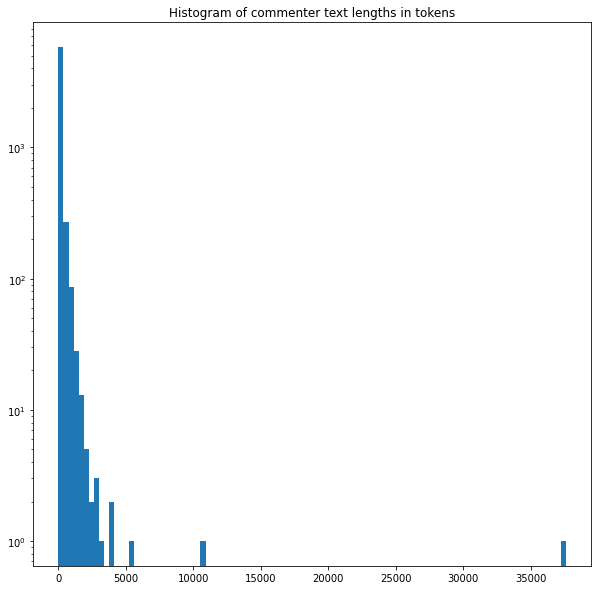

In [20]:
figure(figsize=(10,10))
hist([len(i) for i in commenter_texts.tokens], bins=100, log=True);
title("Histogram of commenter text lengths in tokens");

There are some obvious outliers that post way more material than others. These are probably benign bots. Here are the top posters.

In [25]:
commenter_texts['length'] = commenter_texts['tokens'].str.len()
commenter_texts.sort_values('length', ascending=False, inplace=True)

In [28]:
commenter_texts.head(10)

,comment_body,comment_author,tokens,stems,lemmas,length
5,Take action: **[Join us on Discord](https://di...,AutoModerator,"[Take, action, :, *, *, [, Join, us, on, Disco...","[take, action, :, *, *, [, join, us, on, disco...","[Take, action, :, *, *, [, Join, us, on, Disco...",37578
1054,"This is the best tl;dr I could make, [original...",autotldr,"[This, is, the, best, tl, ;d, r, I, could, mak...","[this, is, the, best, tl, ;d, r, i, could, mak...","[This, be, the, best, tl, ;d, r, I, could, mak...",10884
358,[deleted] [removed] [deleted] [deleted] [remov...,None,"[[, deleted, ], [, removed, ], [, deleted, ], ...","[[, delet, ], [, remov, ], [, delet, ], [, del...","[[, delete, ], [, remove, ], [, delete, ], [, ...",5476
5747,"Not to put too fine a point on it, but this re...",BPC3,"[Not, to, put, too, fine, a, point, on, it, ,,...","[not, to, put, too, fine, a, point, on, it, ,,...","[Not, to, put, too, fine, a, point, on, it, ,,...",4115
4955,/u/h0sti1e17 (OP) has awarded 1 delta(s) in th...,DeltaBot,"[/, u, /, h0sti1e17, (, OP, ), has, awarded, 1...","[/, u, /, h0sti1e17, (, op, ), has, award, 1, ...","[/, u, /, h0sti1e17, (, OP, ), have, award, 1,...",3850
5067,I think an important thing to note is that muc...,badass_panda,"[I, think, an, important, thing, to, note, is,...","[i, think, an, import, thing, to, note, is, th...","[I, think, an, important, thing, to, note, be,...",3197
1698,OAN got started with 65 employees and a partne...,AgoraiosBum,"[OAN, got, started, with, 65, employees, and, ...","[oan, got, start, with, 65, employe, and, a, p...","[OAN, get, start, with, 65, employees, and, a,...",2951
5269,To modify your view here:\n\n>CMV: You cannot ...,thethoughtexperiment,"[To, modify, your, view, here, :, >, CMV, :, Y...","[to, modifi, your, view, here, :, >, cmv, :, y...","[To, modify, your, view, here, :, >, CMV, :, Y...",2803
3916,Submission Statement: This Reuters article re...,theoryofdoom,"[Submission, Statement, :, This, Reuters, arti...","[submiss, statement, :, this, reuter, articl, ...","[Submission, Statement, :, This, Reuters, arti...",2728
1597,"I consider myself a technocrat, if only to eng...",illegalmorality,"[I, consider, myself, a, technocrat, ,, if, on...","[i, consid, myself, a, technocrat, ,, if, onli...","[I, consider, myself, a, technocrat, ,, if, on...",2453


Sure enough, the top posts were by bots, also the "None" author which represents deleted users. However, the next 5 topmost users are interesting.